![alt text](path_to_banner_image.jpg)
# Trends in Supplemental Education Program
Author: Elijah Lopez

## Overview


## Business Problem


## Contingencies

### Sources

In [263]:
# Leads
leads_location = 'data/location_1/leads.csv'

# Accounts
accounts_location = 'data/location_1/accounts.csv'

# Assessment Progress
assessment_progress_location = 'data/location_1/assessment_progress.csv'

### Imports

In [264]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Inferential Statistical Tests
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Helper Functions

In [265]:
"""
Helper Function to:
    Replace spaces with underscoress
    Make all columns lowercase
"""
def standardize_columns(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

In [266]:
def perform_anova(df, group_col, value_col, alpha):
    """
    Performs a one-way ANOVA test to compare means across groups.
    
    Parameters:
        df (pd.dfFrame) - The data containing the groups and values.
        group_col (str) - The column name representing the groups
        value_col (str) - The column name representing the values to compare
        alpha (float) - Confidence level
    
    Returns:
        dict: A dictionary containing the F-Statistic, P-Value, and interpretation
    """
    # Group the df by the specified group column
    grouped = df.groupby(group_col)[value_col]
    
    # Extract values for each group into separate lists
    grouped_values = [grouped.get_group(group).values for group in grouped.groups.keys()]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(*grouped_values)
    
    # Interpretation
    result = {
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Significance": "Reject the null in favor of the alterantive hypothesis."
        if p_value < 0.05 else "Fail to reject the null hypothesis."
    }
    
    return result

In [267]:
def perform_tukeys_hsd(df, group_col, value_col, alpha):
    """
    Perform Tukey's HSD test to determine significant differences between groups.

    Parameters:
        df (pd.DataFrame) - The data containing the groups and values.
        group_col (str) - The column representing groups (e.g., 'month').
        value_col (str) - he column representing the dependent variable (e.g., 'lead_count').
        alpha (float) - Confidence level

    Returns:
        results: Tukey HSD test results.
    """
    tukey = pairwise_tukeyhsd(
        endog=df[value_col],  # The dependent variable
        groups=df[group_col],  # The grouping variable
        alpha=alpha  # Significance level
    )
    print(tukey)
    return tukey


## Leads

### Data

Lead data comes from two distinct sources. To ensure integrity and usability, I merged the datasets into a unified DataFrame, removing duplicate columns and preserving unique information. Additionally, I anonymized the data to maintain confidentiality and protect proprietary details.

In [268]:
# Inspect Contents
leads= pd.read_csv(leads_location)
leads = standardize_columns(leads)
leads.head()

,created_date,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
0,10/11/2021,0,Mail Only,Unconverted,Female,7,Internet
1,2/14/2022,1,Assessed,Converted,NaN,NaN,Not Specified
2,10/19/2021,2,Assessed,Converted,NaN,NaN,Not Specified
3,2/6/2019,0,Open,Unconverted,NaN,NaN,Internet
4,7/28/2021,0,Contacted,Unconverted,Male,12,Location


In [269]:
# See shape of df
leads.shape

(1533, 7)

In [270]:
# Replace 0 for NaN in zipcodes
leads['zip_code'].replace(0, np.NaN, inplace=True)

In [271]:
# View Data Types
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   created_date       1533 non-null   object 
 1   zip_code           541 non-null    float64
 2   lead_status        1497 non-null   object 
 3   conversion_status  1533 non-null   object 
 4   student_gender     374 non-null    object 
 5   grade              806 non-null    object 
 6   lead_source        1533 non-null   object 
dtypes: float64(1), object(6)
memory usage: 84.0+ KB


In [272]:
# Count nulls -- Note: some still exist as non 'null' values
leads.isna().sum()

created_date            0
zip_code              992
lead_status            36
conversion_status       0
student_gender       1159
grade                 727
lead_source             0
dtype: int64

In [273]:
# Not very helpful for zipcodes
leads.describe()

,zip_code
count,541.000000
mean,7.517560
std,7.542114
min,1.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,42.000000


In [274]:
# Transform created_date to datetime and make index
leads['created_date'] = pd.to_datetime(leads['created_date'])
leads.sort_values(by='created_date', ascending=True, inplace=True)
leads.set_index('created_date', inplace=True)

In [275]:
# Calculate date range of data
min_date = leads.index.min().strftime('%Y-%m-%d')
max_date = leads.index.max().strftime('%Y-%m-%d')
print(f'The data includes leads from {min_date} to {max_date}.')

The data includes leads from 2011-08-11 to 2024-12-09.


#### Lead Data Summary

There are 1,533 leads from Aug 2011 - Dec. 2024 measured on 7 features. These include:
* created_date - When the lead first entered the system.
* zip_code - Geographic location; masked for anonyminity. 0 Represents null values.
* lead_status - Where they are at in the pipelien; 36 untracked leads.
* conversion_status - Whether or not they enrolled in service; no nulls.
* student_gender - Most nulls (1,159), indicating this data is not collected consistently upon initial lead contact.
* grade - 727 null values; 'college' and 'k' are forcing string type. Convert to integers.
* lead_source - Nulls represented as 'Not Specified'

### Analysis

Let's first take a look at the distribution of our categorical columns.

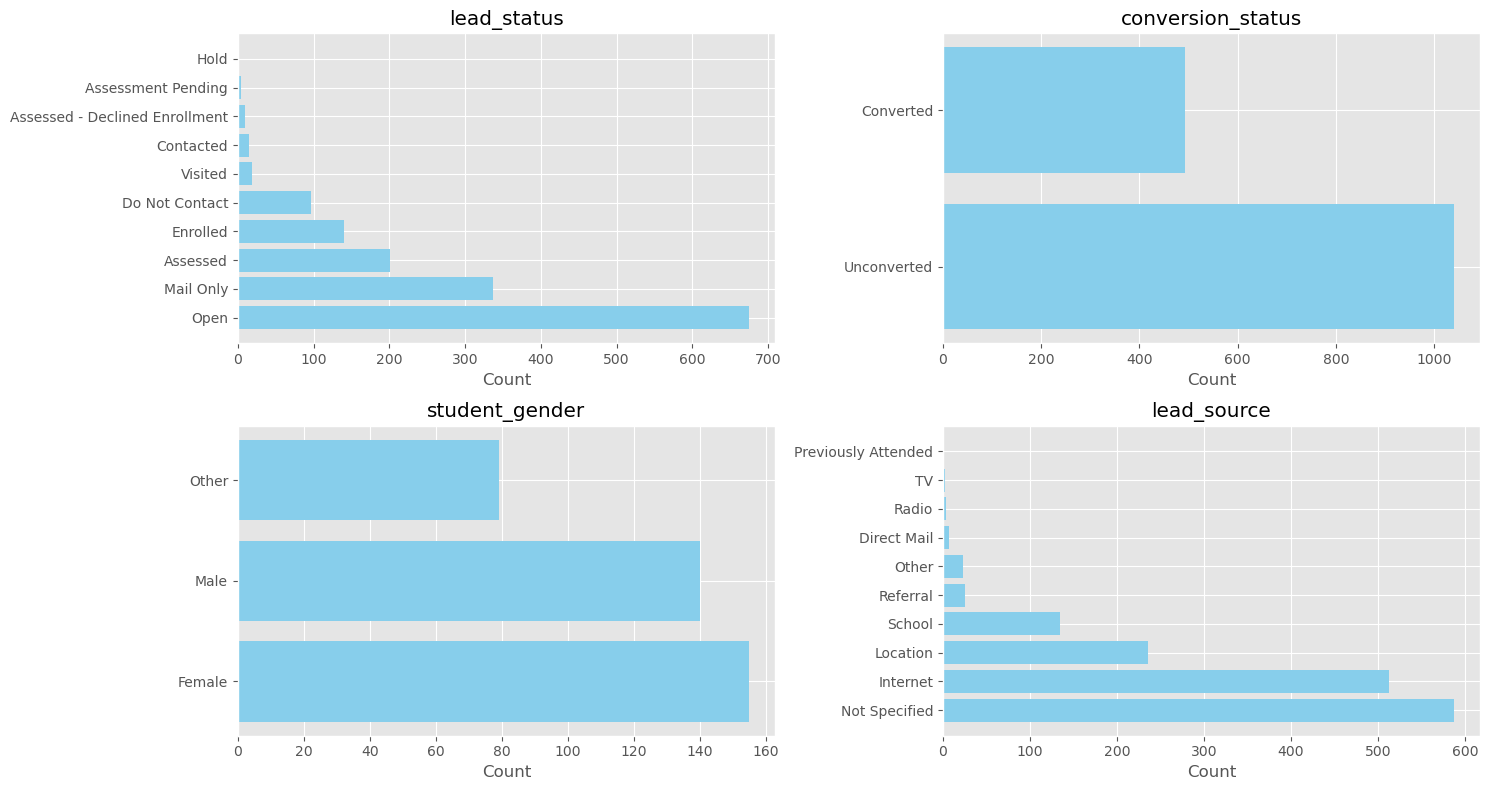

In [276]:
# Identify categorical columns
cat_cols = ['lead_status', 'conversion_status', 'student_gender', 'lead_source']

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

# Apply to each column
for i, column in enumerate(cat_cols):
    x = leads[column].value_counts().index
    y = leads[column].value_counts().values
    
    # Horizontal bar plots
    axes[i].barh(x, y, color='skyblue')
    
    # Add title and labels
    axes[i].set_title(column)
    axes[i].set_xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout();

* Most leads are 'open' which gives rise to the opportunity of advancement in the pipeline.
* Most leads have not been converted, not uncommon in sales.
* Mostly balanced split between male and female students. Other may account for non-binary or null information.
* Most leads have no specified lead source. Most identified leads come from the internet with location being the second most dominant type.

#### Lead Volume Over Time

In [277]:
# Group leads by month
monthly_leads = leads.resample('M').agg(
    converted_leads=('conversion_status', lambda x: (x == 'Converted').sum()),      # Use conversion_status because it has no nulls
    lead_count=('conversion_status', 'count')     
)
monthly_leads

,converted_leads,lead_count
created_date,,
2011-08-31,1,1
2011-09-30,0,0
2011-10-31,0,0
2011-11-30,0,0
2011-12-31,0,0
...,...,...
2024-08-31,3,13
2024-09-30,6,25
2024-10-31,6,16


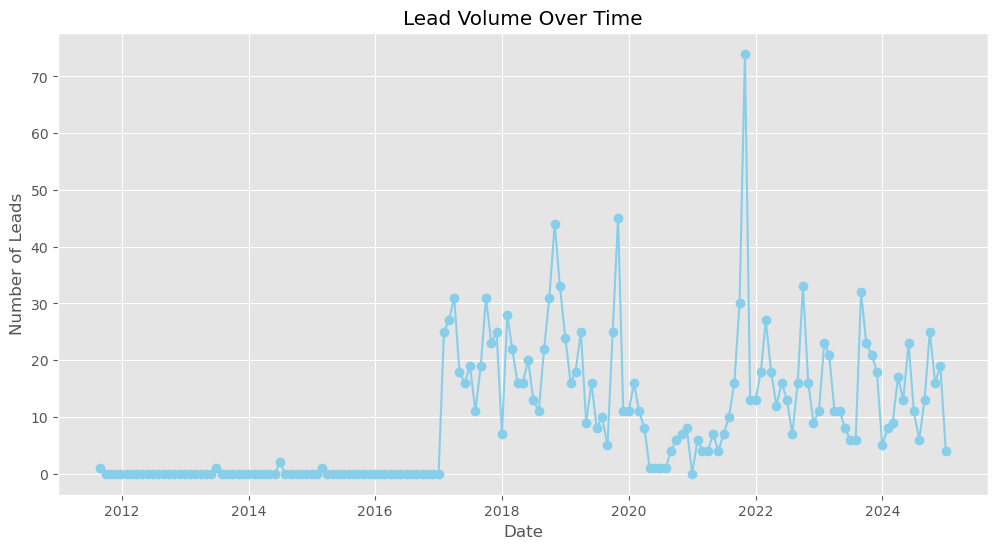

In [278]:
# Data to plot
plt.figure(figsize=(12, 6))
x = monthly_leads.index
y = monthly_leads['lead_count']

# Plot
plt.plot(x, y, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Lead Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Leads')
plt.grid(True)
plt.show();

It looks like leads prior to 2017 were extremely low on a monthly basis. Let's focus on more recent years where the data is more consistent.

In [279]:
# Filter data starting in 2017.
# Data should include last full month. End data Nov 2024.
filtered_monthly_leads = monthly_leads[(monthly_leads.index >= '2017-01-01') & (monthly_leads.index < '2024-12-01')]

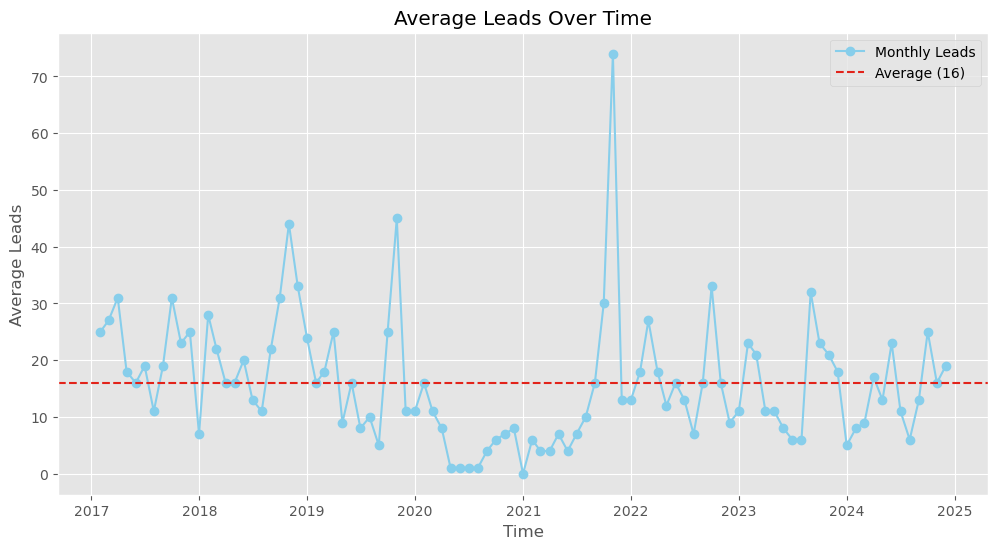

In [377]:
# Data to plot
plt.figure(figsize=(12, 6))
x = filtered_monthly_leads.index
y = filtered_monthly_leads['lead_count']

# Plot
plt.plot(x, y, marker='o', linestyle='-', color='skyblue', label='Monthly Leads')

# Calculate and plot the mean
average_leads = filtered_monthly_leads['lead_count'].mean()
plt.axhline(y=average_leads, color='#E2231A', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title, labels, and legend
plt.title('Average Leads Over Time')
plt.xlabel('Time')
plt.ylabel('Average Leads')
plt.legend()
plt.grid(True)
plt.show();

Here we see average leads per month is 16.

#### Lead Volume per Month

In [281]:
# Create 'month' column and set equal to 3 letter abbreviation
filtered_monthly_leads['month'] = filtered_monthly_leads.index.month_name().str[:3]

# Group by month and calculate the mean for each
monthly_mean = filtered_monthly_leads.groupby('month').mean()

monthly_mean

C:\Users\Elija\AppData\Local\Temp\ipykernel_23328\3746171043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_monthly_leads['month'] = filtered_monthly_leads.index.month_name().str[:3]


,converted_leads,lead_count
month,,
Apr,2.875000,10.875000
Aug,3.500000,15.875000
Dec,3.428571,10.142857
Feb,6.750000,17.375000
Jan,6.875000,17.500000
Jul,2.375000,7.750000
Jun,4.250000,9.750000
Mar,6.500000,16.250000
May,5.250000,13.000000


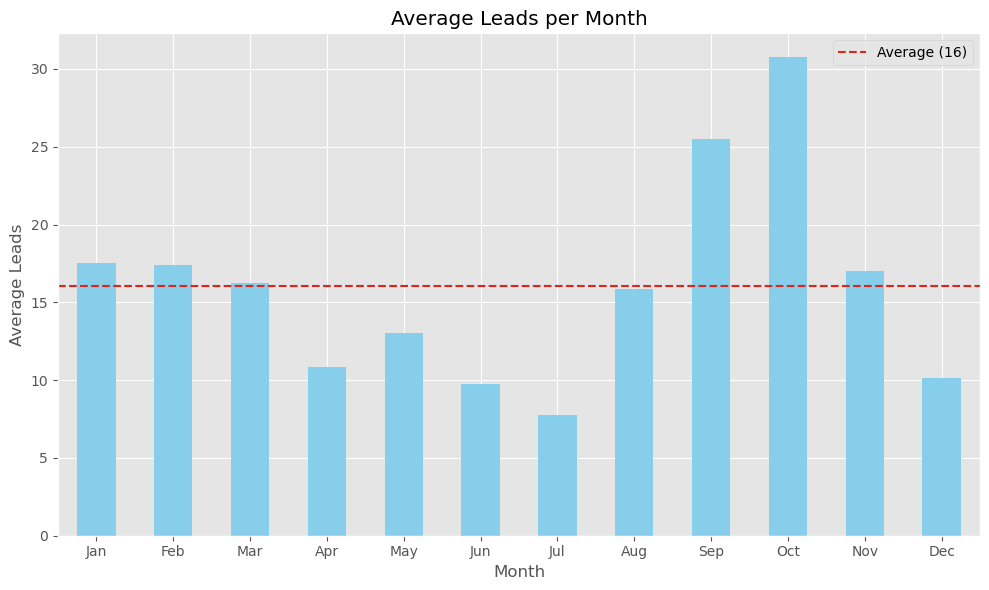

In [375]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_mean = monthly_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
monthly_mean['lead_count'].plot(kind='bar', color='skyblue', label='')
plt.axhline(y=average_leads, color='#E2231A', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title and labels
plt.title('Average Leads per Month')
plt.xlabel('Month')
plt.ylabel('Average Leads')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout();

Here we see that lead volume is:
* Highest in September (26) and October (31) -- Roughly corresponding with the end of the 1st quarter
* Lowest in June (10) & July (8) -- Corresponding with summer

##### Statistical Testing

Because I am comparing multiple groups I will conduct an ANOVA test.
* H0: There is not a significant difference in lead volume for different months of the year.
* H1: There is a significant difference in lead volume for different months of the year.
* Alpha = 0.05

In [283]:
# Run ANOVA Test
perform_anova(filtered_monthly_leads, 'month', 'lead_count', 0.05)

{'F-Statistic': 3.7757495107575205,
 'P-Value': 0.00021142382968498226,
 'Significance': 'Reject the null in favor of the alterantive hypothesis.'}

Because the above result was significant I will follow up with Tukey's HSD to find which months have a significant difference.
* H0: The mean lead volume of month A and month B are not significantly different.
* H1: The mean lead volume of month A and month B are significantly different.
* Alpha = 0.05

In [284]:
# Follow up with Tukey's HSD
tukey_results = perform_tukeys_hsd(filtered_monthly_leads, 'month', 'lead_count', 0.05)
tukey_results

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   Apr    Aug      5.0 0.9964 -11.2599 21.2599  False
   Apr    Dec  -0.7321    1.0 -17.5627 16.0984  False
   Apr    Feb      6.5 0.9704  -9.7599 22.7599  False
   Apr    Jan    6.625  0.966  -9.6349 22.8849  False
   Apr    Jul   -3.125    1.0 -19.3849 13.1349  False
   Apr    Jun   -1.125    1.0 -17.3849 15.1349  False
   Apr    Mar    5.375 0.9933 -10.8849 21.6349  False
   Apr    May    2.125    1.0 -14.1349 18.3849  False
   Apr    Nov    6.125  0.981 -10.1349 22.3849  False
   Apr    Oct   19.875 0.0049   3.6151 36.1349   True
   Apr    Sep   14.625 0.1199  -1.6349 30.8849  False
   Aug    Dec  -5.7321 0.9915 -22.5627 11.0984  False
   Aug    Feb      1.5    1.0 -14.7599 17.7599  False
   Aug    Jan    1.625    1.0 -14.6349 17.8849  False
   Aug    Jul   -8.125 0.8718 -24.3849  8.1349  False
   Aug    Jun   -6.125  0.98

In [285]:
# Create data frame to easily identify pairs with statistically significant results
tukey_df = pd.DataFrame(tukey_results.summary().data[1:])
tukey_data = tukey_results.summary().data[1:]
tukey_columns = tukey_results.summary().data[0]
tukey_df = pd.DataFrame(data=tukey_data, columns=tukey_columns)

# Isolate significant differences
tukey_df.loc[tukey_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Apr,Oct,19.8750,0.0049,3.6151,36.1349,True
28,Dec,Oct,20.6071,0.0048,3.7766,37.4377,True
49,Jul,Oct,23.0000,0.0005,6.7401,39.2599,True
50,Jul,Sep,17.7500,0.0204,1.4901,34.0099,True
54,Jun,Oct,21.0000,0.0022,4.7401,37.2599,True
61,May,Oct,17.7500,0.0204,1.4901,34.0099,True


* October has significantly more leads than April, May, June, July, and December.
* September has significantly more leads than July. 
* All other months do not show a significant difference

#### Number of Leads Converted Over Time

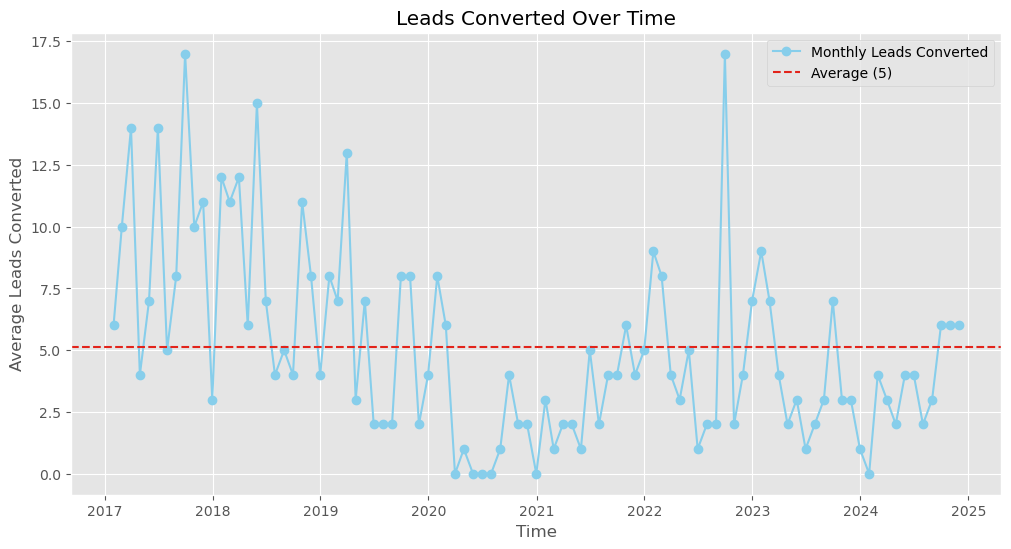

In [ ]:
# Data to plot
plt.figure(figsize=(12, 6))
x = filtered_monthly_leads.index
y = filtered_monthly_leads['converted_leads']

# Plot
plt.plot(x, y, marker='o', linestyle='-', color='skyblue', label='Monthly Leads Converted')

# Calculate and plot the mean
average_converted_leads = filtered_monthly_leads['converted_leads'].mean()

# Plot the mean
plt.axhline(y=average_converted_leads, color='#E2231A', linestyle='--', label=f'Average ({average_converted_leads:.0f})')

# Add title, labels, and legend
plt.title('Leads Converted Over Time')
plt.xlabel('Time')
plt.ylabel('Average Leads Converted')
plt.legend()
plt.grid(True)
plt.show();

Here we see average number of leads converted per month is 5.

#### Number of Leads Converted per Month

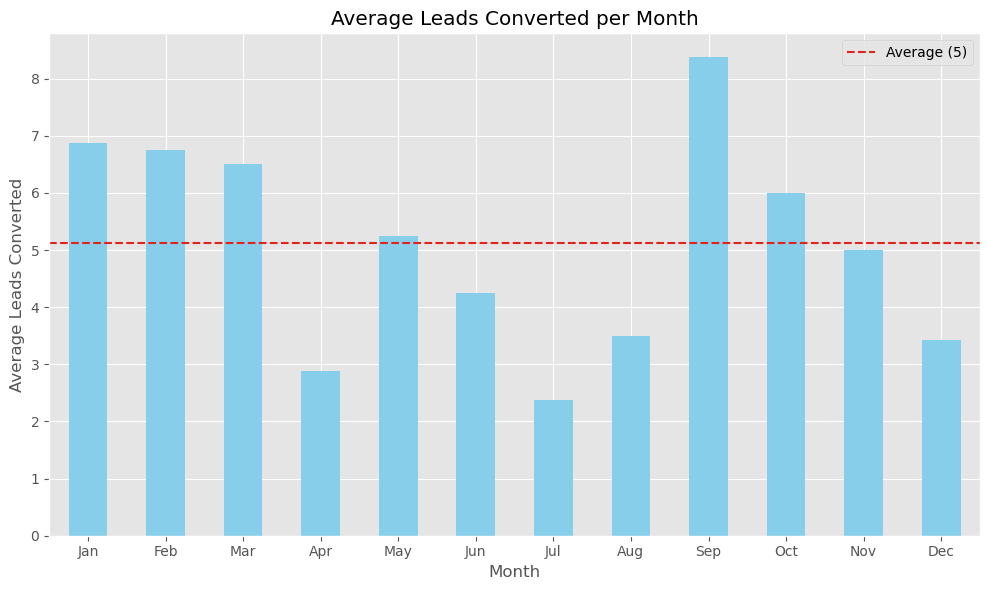

In [ ]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_mean = monthly_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
monthly_mean['converted_leads'].plot(kind='bar', color='skyblue', label='')

# Plot the mean
plt.axhline(y=average_converted_leads, color='#E2231A', linestyle='--', label=f'Average ({average_converted_leads:.0f})')

# Add title and labels
plt.title('Average Leads Converted per Month')
plt.xlabel('Month')
plt.ylabel('Average Leads Converted')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout();

#### Percent Lead Conversion Over Time

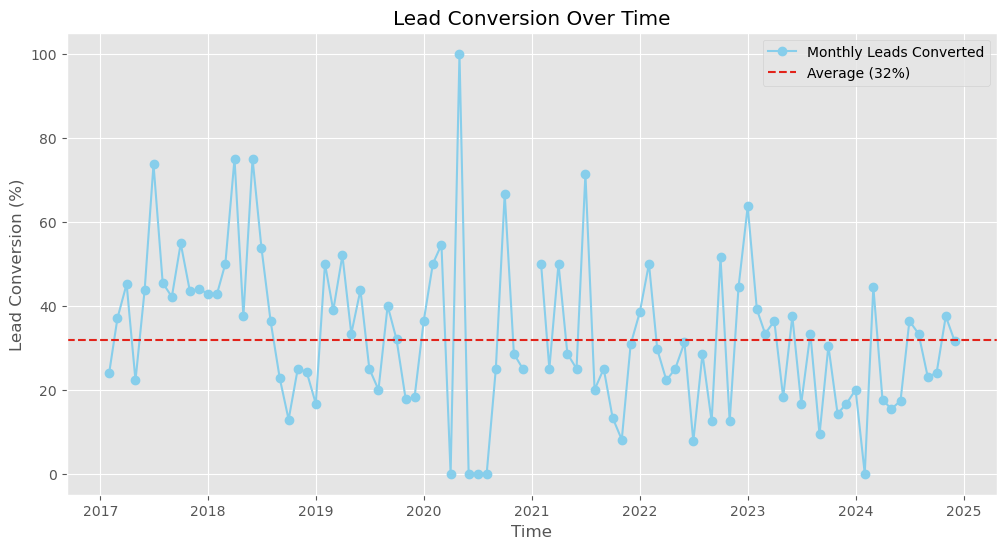

In [400]:
# Data to plot
plt.figure(figsize=(12, 6))
x = filtered_monthly_leads.index
y = filtered_monthly_leads['converted_leads'] / filtered_monthly_leads['lead_count'] * 100

# Plot
plt.plot(x, y, marker='o', linestyle='-', color='skyblue', label='Monthly Leads Converted')

# Calculate and plot the mean
percent_converted_leads = filtered_monthly_leads['converted_leads'].sum() / filtered_monthly_leads['lead_count'].sum() * 100
plt.axhline(y=percent_converted_leads, color='#E2231A', linestyle='--', label=f'Average ({percent_converted_leads:.0f}%)')

# Add title, labels, and legend
plt.title('Lead Conversion Over Time')
plt.xlabel('Time')
plt.ylabel('Lead Conversion (%)')
plt.legend()
plt.grid(True)
plt.show();

Here we see average percent lead conversion per month is 32.

#### Percent Lead Conversion per Month

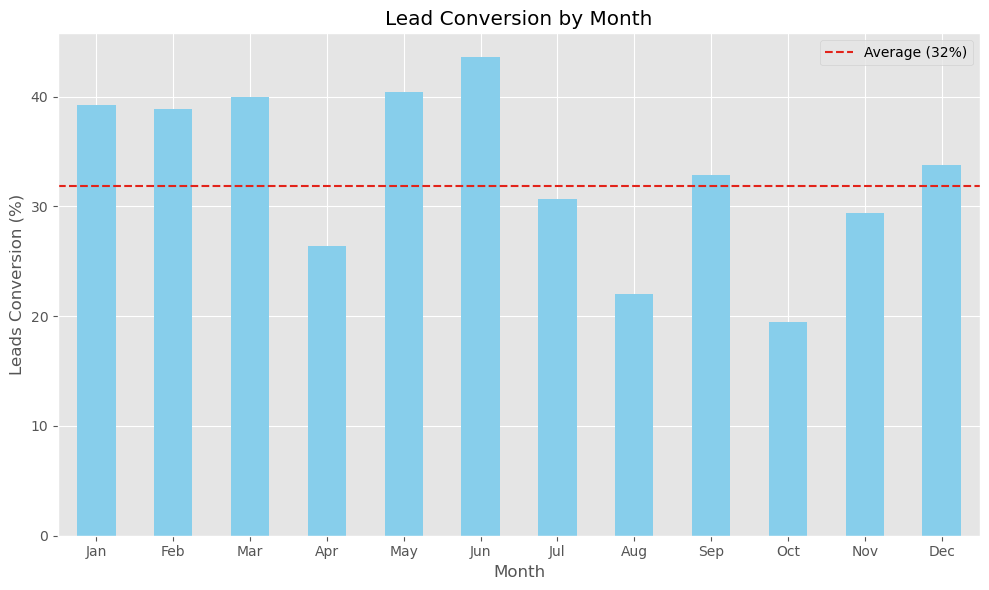

In [ ]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_mean = monthly_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
monthly_mean_ratio = monthly_mean['converted_leads'] / monthly_mean['lead_count'] * 100
monthly_mean_ratio.plot(kind='bar', color='skyblue', label='')

# Plot the mean
plt.axhline(y=percent_converted_leads, color='#E2231A', linestyle='--', label=f'Average ({percent_converted_leads:.0f}%)')

# Add title and labels
plt.title('Lead Conversion by Month')
plt.xlabel('Month')
plt.ylabel('Leads Conversion (%)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout();

#### Grade

Grade is updated every year to keep track of students over time. We'll have to calculate the grade at time of lead creation to make this useful. Because 'college' (13) is a fixed value, students with that label will be excluded from this calculation.

In [291]:
# Create map to replace 'College' and 'K'
grade_map = {
    'College': 13,
    'K': 0
}

In [292]:
# Replace
leads['grade'] = leads['grade'].replace(grade_map)

In [293]:
# Copy Leads df and isolate those where Grade is not NaN or 13
lead_student_grades = leads.copy()
lead_student_grades = lead_student_grades.loc[(lead_student_grades['grade'] != 13) & (lead_student_grades['grade'].notna())]

In [294]:
# Calculate elapsed time
lead_student_grades['elapsed_years'] = (pd.to_datetime('now') - lead_student_grades.index)

# Convert to years
lead_student_grades['elapsed_years'] = round(lead_student_grades['elapsed_years'].dt.total_seconds() / (60 * 60 * 24 * 365.25), 0)
lead_student_grades.head()

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source,elapsed_years
created_date,,,,,,,
2017-01-07,NaN,Assessed - Declined Enrollment,Unconverted,Other,5,Internet,8.0
2017-01-09,NaN,Assessed,Unconverted,Male,12,Internet,8.0
2017-01-10,NaN,Do Not Contact,Unconverted,Male,8,Internet,8.0
2017-01-16,NaN,Open,Unconverted,Other,5,Internet,8.0
2017-01-23,NaN,Mail Only,Unconverted,Other,5,Direct Mail,8.0


In [295]:
lead_student_grades['grade'] = lead_student_grades['grade'].astype(int)
lead_student_grades['grade_when_created'] = lead_student_grades['grade'] - lead_student_grades['elapsed_years']
lead_student_grades.head()

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source,elapsed_years,grade_when_created
created_date,,,,,,,,
2017-01-07,NaN,Assessed - Declined Enrollment,Unconverted,Other,5,Internet,8.0,-3.0
2017-01-09,NaN,Assessed,Unconverted,Male,12,Internet,8.0,4.0
2017-01-10,NaN,Do Not Contact,Unconverted,Male,8,Internet,8.0,0.0
2017-01-16,NaN,Open,Unconverted,Other,5,Internet,8.0,-3.0
2017-01-23,NaN,Mail Only,Unconverted,Other,5,Direct Mail,8.0,-3.0


In [296]:
lead_student_grades['grade_when_created'].value_counts()

grade_when_created
 5.0     100
 4.0      89
 3.0      83
 2.0      72
 6.0      62
 0.0      45
 7.0      43
 8.0      41
 1.0      40
 9.0      26
-3.0      19
 10.0     16
-1.0       8
 11.0      7
-2.0       5
 12.0      2
-4.0       1
Name: count, dtype: int64

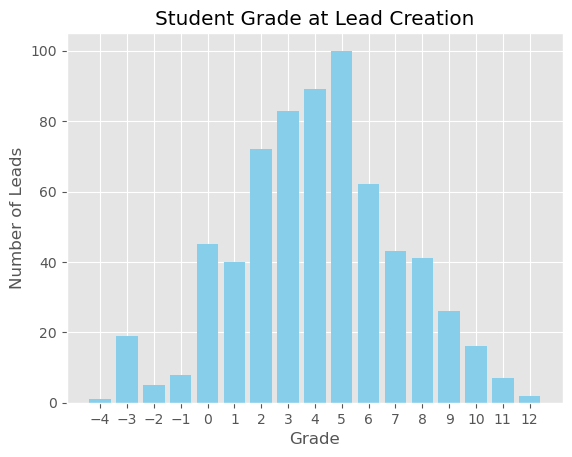

In [297]:
# Data to plot
x = lead_student_grades['grade_when_created'].value_counts().index
y = lead_student_grades['grade_when_created'].value_counts().values

# Plot
plt.bar(x, y, color='skyblue')

# Add title and labels
plt.title('Student Grade at Lead Creation')
plt.xlabel('Grade')
plt.xticks(range(int(x.min()), int(x.max()) + 1))
plt.ylabel('Number of Leads')
plt.show();

Here we see that some inquiries happen prior to Kindergarten, while most occur in 5th grade.

#### Lead Source

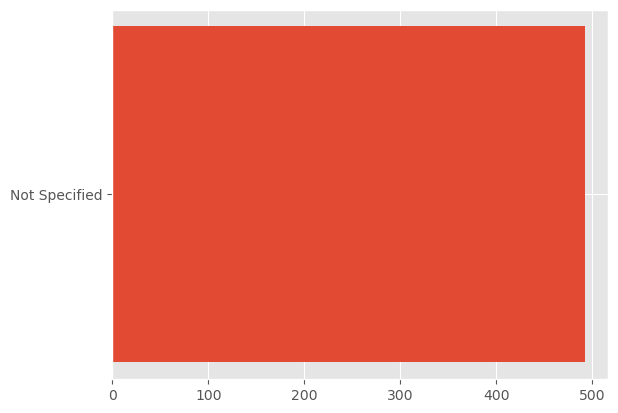

In [298]:
# Isolate Converted Leads
converted_leads = leads.loc[leads['conversion_status'] == 'Converted']

x = converted_leads['lead_source'].value_counts().index
y = converted_leads['lead_source'].value_counts().values

plt.barh(x, y);

This shows that all converted leads show lead source as null. After investigating the data source I see that the tracked information is only available on another document with a limited time window of accessibility.

In [299]:
converted_leads.loc[converted_leads['lead_status'] != 'Enrolled']

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
created_date,,,,,,
2011-08-11,1.0,Open,Converted,NaN,NaN,Not Specified
2014-06-05,10.0,Assessed,Converted,NaN,NaN,Not Specified
2017-01-07,1.0,Open,Converted,NaN,NaN,Not Specified
2017-02-04,NaN,Assessed,Converted,NaN,NaN,Not Specified
2017-06-30,15.0,Open,Converted,NaN,NaN,Not Specified
...,...,...,...,...,...,...
2023-09-21,20.0,Open,Converted,NaN,NaN,Not Specified
2023-10-12,5.0,Contacted,Converted,NaN,NaN,Not Specified
2023-10-19,32.0,Assessed,Converted,NaN,NaN,Not Specified


This shows a similar issue where not all converted accounts show an updated lead status of 'enrolled'. It could also indicate that these famiies were once enrolled but are not currently.

## Insert here

#### Leads by Zip Code

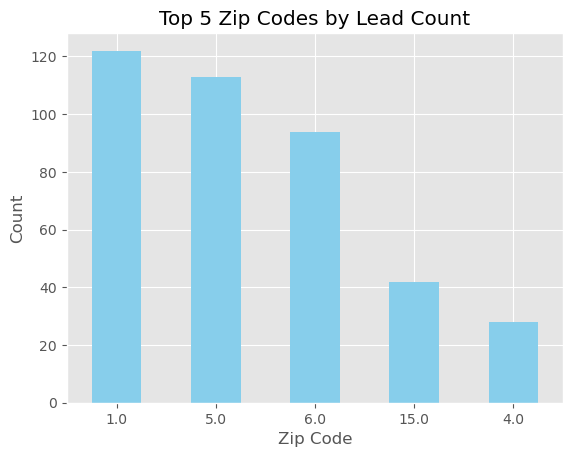

In [300]:
# Top 5 Zip Codes by Lead Volume
top_zip_codes_count = leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_count.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Lead Count')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

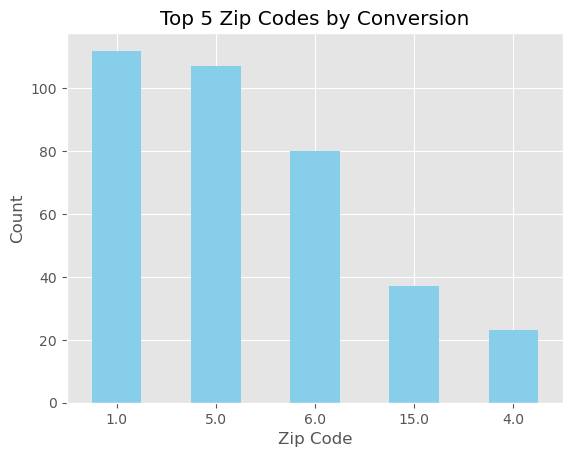

In [301]:
# Top 5 Zip Codes by Conversion
top_zip_codes_converted = converted_leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_converted.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Conversion')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

Zip Code Counts for converted leads is almost identical to the Zip Code Count for all Leads. This indicates that this information is likely captured after the enrollment, not during initial lead contact.

##### Recommendations

* Target marketing campaigns in areas with highest conversion rates
* Collect zip codes upon initial lead intake to better track lead volume and lead conversion rates per zip code.

___

### Accounts

In [302]:
# Inspect contents
accounts = pd.read_csv(accounts_location)
accounts = standardize_columns(accounts)
accounts.head()

,grade,status,membership_type,primary_enrollment_start,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
0,College,Inactive,Sessions Package,6/4/2018,7/6/2018,1 month,1 month,10,0
1,College,Inactive,Flexible,7/7/2018,9/1/2019,13.8 months,13.8 months,0,0
2,College,Inactive,Flexible,10/14/2019,3/31/2020,5.6 months,5.6 months,0,0
3,12,Inactive,Flexible,2/20/2020,6/2/2020,3.4 months,1.4 months,0,0
4,College,Inactive,Flexible,1/20/2017,2/24/2017,1.2 months,1.2 months,0,0


In [303]:
# See shape of df
accounts.shape

(653, 9)

In [304]:
# View Data Types
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   grade                       653 non-null    object
 1   status                      653 non-null    object
 2   membership_type             653 non-null    object
 3   primary_enrollment_start    653 non-null    object
 4   primary_enrollment_end      653 non-null    object
 5   enrollment_contract_length  653 non-null    object
 6   enrollment_length_of_stay   653 non-null    object
 7   total_sessions              653 non-null    int64 
 8   referral_account            653 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 46.0+ KB


In [305]:
# Check for nulls -- Thankfully, NONE!
accounts.isna().sum()

grade                         0
status                        0
membership_type               0
primary_enrollment_start      0
primary_enrollment_end        0
enrollment_contract_length    0
enrollment_length_of_stay     0
total_sessions                0
referral_account              0
dtype: int64

In [306]:
accounts.describe()

,total_sessions,referral_account
count,653.000000,653.000000
mean,4.251149,0.016845
std,11.167081,0.128790
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,8.000000,0.000000
max,99.000000,1.000000


In [307]:
accounts['membership_type'].value_counts()

membership_type
Flexible                                      412
Monthly Sessions                              129
Private Sessions Package                       39
Sessions Package                               35
Credits (Monthly Sessions)                     14
Summer Session Packages (Sessions Package)      9
Monthly Sessions (4x) (Monthly Sessions)        6
Summer 2024 (Private Sessions Package)          3
Summer Promotion (Sessions Package)             2
Unlimited Monthly Program (Flexible)            1
Summer Membership (Flexible)                    1
Enrollment Fee Only (Monthly Sessions)          1
Groupon (Sessions Package)                      1
Name: count, dtype: int64

In [308]:
accounts['total_sessions'].value_counts()

total_sessions
0     414
8     107
12     38
10     30
1      25
17     14
4      10
99      7
24      2
40      2
5       1
13      1
2       1
20      1
Name: count, dtype: int64

There are 653 listed accounts measured on 10 features.
* grade - Current grade; 'college' and 'k' are forcing string type. Convert to integers.
* status - Enrolled or inactive
* membership_type - Remove 'credits' and consolidate remaining
* primary_enrollment_start - Convert to datetime
* primary_enrollment_end - Convert to datetime
* enrollment_contract_length - Remove unit from entry. Convert to integers.
* enrollment_length_of_stay - Remove unit from entry. Convert to integers.
* total_sessions - Allowable sessions based on enrollment type, NOT total attended
* referral_account - 1 = yes, 0 = no

In [309]:
# Replace 'college' with 13 and 'k' with 0
accounts['grade'] = accounts['grade'].replace(grade_map)

In [310]:
# Remove 'credit' type enrollments from data frame
accounts = accounts[accounts['membership_type'] != 'Credits (Monthly Sessions)']

In [311]:
# Convert enrollment dates to date time
accounts['primary_enrollment_start'] = pd.to_datetime(accounts['primary_enrollment_start'])
accounts['primary_enrollment_end'] = pd.to_datetime(accounts['primary_enrollment_end'])

# Set index to enrollment start date and sort by date
accounts.set_index('primary_enrollment_start', inplace=True)
accounts.sort_index(ascending=True, inplace=True)

In [312]:
# Strip enrollment_contract_length & enrollment_length_of_stay of the word 'months'
accounts['enrollment_contract_length'] = accounts['enrollment_contract_length'].str.split(' ').str[0]
accounts['enrollment_length_of_stay'] = accounts['enrollment_length_of_stay'].str.split(' ').str[0]

# Convert to float
accounts['enrollment_length_of_stay'] = pd.to_numeric(accounts['enrollment_length_of_stay'], errors='coerce')
accounts['enrollment_contract_length'] = pd.to_numeric(accounts['enrollment_contract_length'], errors='coerce')

In [313]:
accounts['membership_type'].value_counts()

membership_type
Flexible                                      412
Monthly Sessions                              129
Private Sessions Package                       39
Sessions Package                               35
Summer Session Packages (Sessions Package)      9
Monthly Sessions (4x) (Monthly Sessions)        6
Summer 2024 (Private Sessions Package)          3
Summer Promotion (Sessions Package)             2
Groupon (Sessions Package)                      1
Enrollment Fee Only (Monthly Sessions)          1
Unlimited Monthly Program (Flexible)            1
Summer Membership (Flexible)                    1
Name: count, dtype: int64

In [314]:
# Create map for various membership types
def map_program_type(program_type):
    if 'Fee' in program_type:
        return 'Other'
    elif 'Flexible' in program_type:
        return 'Flexible'
    elif 'Monthly' in program_type:
        return 'Monthly Sessions'
    elif 'Private' in program_type:
        return 'Private Sessions'
    elif 'Sessions' in program_type:
        return 'Session Packages'
    else:
        return 'Other'

In [315]:
# Apply mapping to membership_type
accounts['membership_type'] = accounts['membership_type'].apply(map_program_type)
membership_type_counts = accounts['membership_type'].value_counts()
membership_type_counts

membership_type
Flexible            414
Monthly Sessions    135
Session Packages     47
Private Sessions     42
Other                 1
Name: count, dtype: int64

In [316]:
# Percentage of recurring enrollment types
percent_recurring_enrollments = (membership_type_counts['Flexible'] + membership_type_counts['Monthly Sessions']) / membership_type_counts.sum() * 100
print(f'The percentage of enrollments that choose a recurring program is: {percent_recurring_enrollments:.0f}%')

The percentage of enrollments that choose a recurring program is: 86%


In [317]:
# Copy Accounts df and isolate those where Grade is not NaN or 13
account_student_grades = accounts.copy()
account_student_grades = account_student_grades.loc[(account_student_grades['grade'] != 13) & (account_student_grades['grade'].notna())]

# Calculate elapsed time
account_student_grades['elapsed_years'] = (pd.to_datetime('now') - account_student_grades.index)

# Convert to years
account_student_grades['elapsed_years'] = round(account_student_grades['elapsed_years'].dt.total_seconds() / (60 * 60 * 24 * 365.25), 0)
account_student_grades.head()

account_student_grades['grade'] = account_student_grades['grade'].astype(int)
account_student_grades['grade_when_created'] = account_student_grades['grade'] - account_student_grades['elapsed_years']
account_student_grades.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account,elapsed_years,grade_when_created
primary_enrollment_start,,,,,,,,,,
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0,10.0,1.0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0,9.0,2.0
2016-08-17,11,Inactive,Flexible,2017-06-01,9.5,9.5,0,0,8.0,3.0
2017-02-01,12,Inactive,Flexible,2017-08-31,6.9,6.9,0,0,8.0,4.0
2017-02-15,12,Inactive,Flexible,2017-09-01,6.5,6.5,0,0,8.0,4.0


In [318]:
account_student_grades['grade_when_created'].value_counts()

grade_when_created
 5.0     78
 4.0     67
 6.0     57
 3.0     47
 7.0     44
 2.0     38
 8.0     33
 9.0     32
 1.0     16
 10.0    12
 11.0     9
 0.0      6
-1.0      3
-2.0      3
 12.0     2
-3.0      1
Name: count, dtype: int64

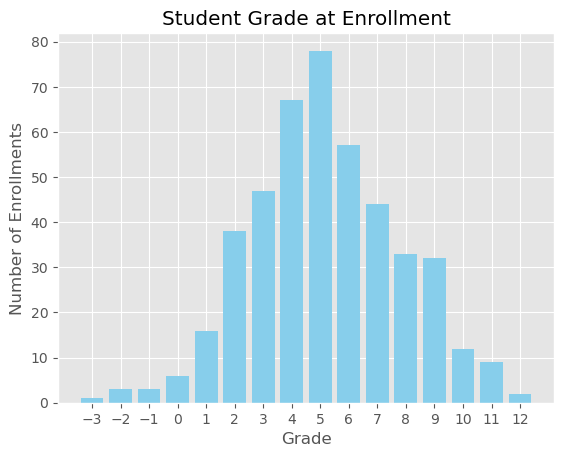

In [319]:
x = account_student_grades['grade_when_created'].value_counts().index
y = account_student_grades['grade_when_created'].value_counts().values

plt.bar(x, y, color='skyblue')

plt.title('Student Grade at Enrollment')
plt.xlabel('Grade')
plt.xticks(range(int(x.min()), int(x.max()) + 1))
plt.ylabel('Number of Enrollments')

plt.show();

In [320]:
def assign_grade_range(grade):
    """
    Function to assign grade range based on grade
    """

    if grade >= 9:
        return 'High'
    elif 5 < grade < 9:
        return 'Middle'
    else:
        return 'Elementary'

In [321]:
# Create new column for grade range
account_student_grades['grade_range'] = account_student_grades['grade_when_created'].apply(assign_grade_range)

In [322]:
account_student_grades.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account,elapsed_years,grade_when_created,grade_range
primary_enrollment_start,,,,,,,,,,,
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0,10.0,1.0,Elementary
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0,9.0,2.0,Elementary
2016-08-17,11,Inactive,Flexible,2017-06-01,9.5,9.5,0,0,8.0,3.0,Elementary
2017-02-01,12,Inactive,Flexible,2017-08-31,6.9,6.9,0,0,8.0,4.0,Elementary
2017-02-15,12,Inactive,Flexible,2017-09-01,6.5,6.5,0,0,8.0,4.0,Elementary


In [323]:
account_student_grades['grade_range'].value_counts()

grade_range
Elementary    259
Middle        134
High           55
Name: count, dtype: int64

In [324]:
# Group by grade_range and membership_type
membership_by_grade_range = account_student_grades.groupby(['grade_range', 'membership_type']).size()
membership_by_grade_range

grade_range  membership_type 
Elementary   Flexible            176
             Monthly Sessions     56
             Private Sessions      4
             Session Packages     23
High         Flexible             22
             Monthly Sessions     20
             Other                 1
             Private Sessions     10
             Session Packages      2
Middle       Flexible             73
             Monthly Sessions     49
             Private Sessions      7
             Session Packages      5
dtype: int64

In [325]:
# Create pivot table
membership_pivot = membership_by_grade_range.unstack(fill_value=0)
membership_percent = membership_pivot.div(membership_pivot.sum(axis=1), axis=0)  # Row-wise normalization

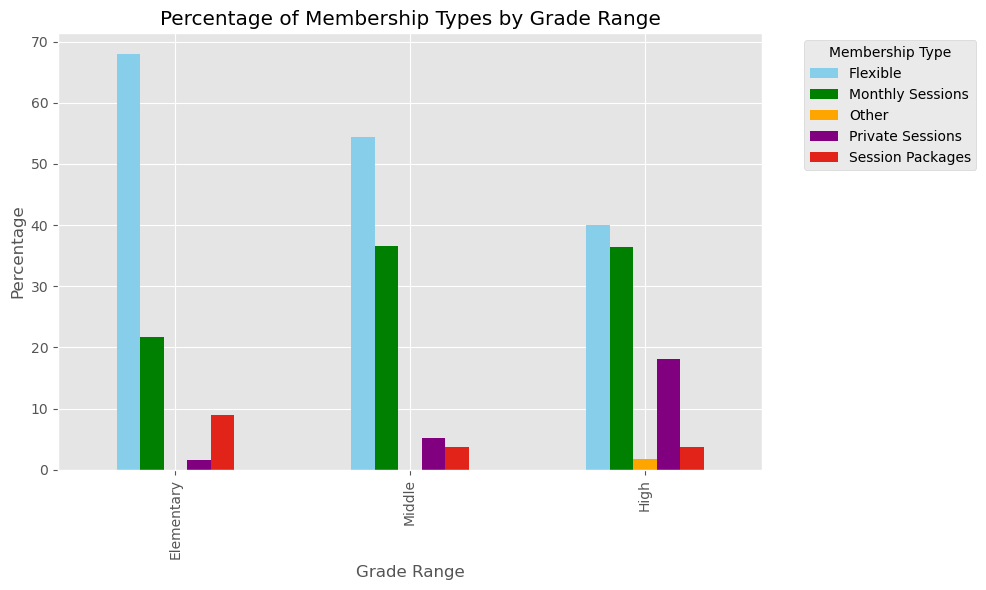

In [326]:
# Specify display order
grade_order = ['Elementary', 'Middle', 'High']
membership_percent.index = pd.CategoricalIndex(membership_percent.index, categories=grade_order, ordered=True)
membership_percent = membership_percent.sort_index()  * 100

# Plot side-by-side percentage bars
membership_percent.plot(
    figsize=(10, 6),
    kind='bar',
    stacked=False,
    color=['skyblue', 'green', 'orange', 'purple', '#E2231A']
)

# Add title and labels
plt.title('Percentage of Membership Types by Grade Range')
plt.xlabel('Grade Range')
plt.ylabel('Percentage')
plt.legend(title='Membership Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()
plt.show();

In [327]:
accounts.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
primary_enrollment_start,,,,,,,,
2013-06-28,13,Inactive,Flexible,2014-08-31,14.1,14.1,0,0
2014-07-17,13,Inactive,Flexible,2015-04-30,9.4,9.4,0,0
2015-02-22,13,Inactive,Flexible,2016-01-31,11.3,11.3,0,0
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0


In [328]:
print(accounts['membership_type'].unique())  # Check unique values to see what we have


['Flexible' 'Session Packages' 'Private Sessions' 'Monthly Sessions'
 'Other']


In [329]:
place_holder = accounts['membership_type'] == 'Monthly Sessions'
accounts.loc[place_holder, 'membership_type'] = accounts.loc[place_holder, 'total_sessions'].astype(str) + 'x'

In [330]:
accounts.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
primary_enrollment_start,,,,,,,,
2013-06-28,13,Inactive,Flexible,2014-08-31,14.1,14.1,0,0
2014-07-17,13,Inactive,Flexible,2015-04-30,9.4,9.4,0,0
2015-02-22,13,Inactive,Flexible,2016-01-31,11.3,11.3,0,0
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0


In [331]:
accounts['membership_type'].value_counts()

membership_type
Flexible            414
8x                   94
Session Packages     47
Private Sessions     42
12x                  31
4x                   10
Other                 1
Name: count, dtype: int64

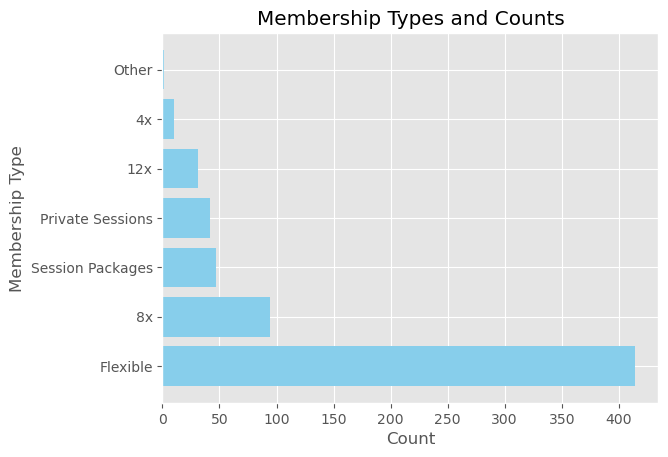

In [332]:
x = accounts['membership_type'].value_counts().index
y = accounts['membership_type'].value_counts().values

plt.barh(x, y, color='skyblue')

plt.title('Membership Types and Counts');
plt.xlabel('Count')
plt.ylabel('Membership Type')
plt.show();

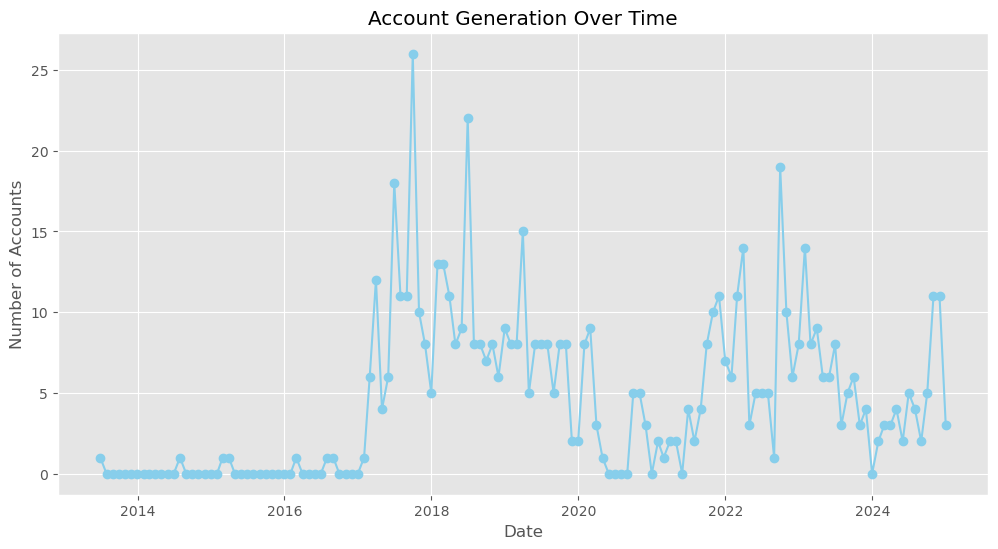

In [333]:
# Group enrollments by month
monthly_accounts = accounts['membership_type'].resample('M').count()    # Use membership_type because it has no nulls
monthly_accounts.index = pd.to_datetime(monthly_accounts.index)
monthly_accounts

# Plot monthly enrollments over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_accounts.index, monthly_accounts.values, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Account Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accounts')
plt.grid(True)
plt.show();

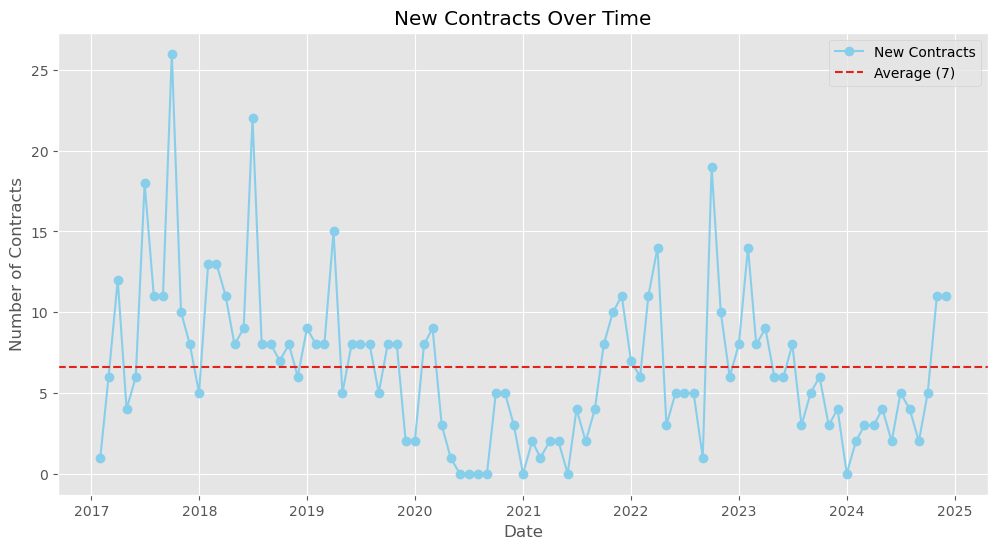

In [334]:
# Filter date >= 2017-01-01 and group by month
filtered_monthly_accounts_start = monthly_accounts[(monthly_accounts.index >= '2017-01-01') & (monthly_accounts.index < '2024-12-01')]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(filtered_monthly_accounts_start.index, filtered_monthly_accounts_start.values, marker='o', linestyle='-', color='skyblue', label='New Contracts')

# Calculate and plot the mean
average_leads = filtered_monthly_accounts_start.mean()
plt.axhline(y=average_leads, color='#E2231A', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title, labels, and legend
plt.title('New Contracts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.legend()
plt.grid(True)
plt.show();

Note: This data includes students that re-enroll and siblings recorded under the same lead account so direct comparison to lead chart above will not match overall Lead Conversion.

New Enrollment Agreements by Month Start

In [335]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_accounts_start = filtered_monthly_accounts_start.to_frame()
filtered_monthly_accounts_start['month'] = filtered_monthly_accounts_start.index.month_name().str[:3]
filtered_monthly_accounts_start.rename(columns={'membership_type': 'enrollments'}, inplace=True)

# Group by month and calculate the mean for each
enrollment_mean = filtered_monthly_accounts_start.groupby('month').mean()
enrollment_mean

,enrollments
month,
Apr,4.125000
Aug,4.500000
Dec,4.428571
Feb,7.375000
Jan,6.750000
Jul,5.125000
Jun,8.750000
Mar,8.625000
May,4.500000


<Figure size 1000x600 with 0 Axes>

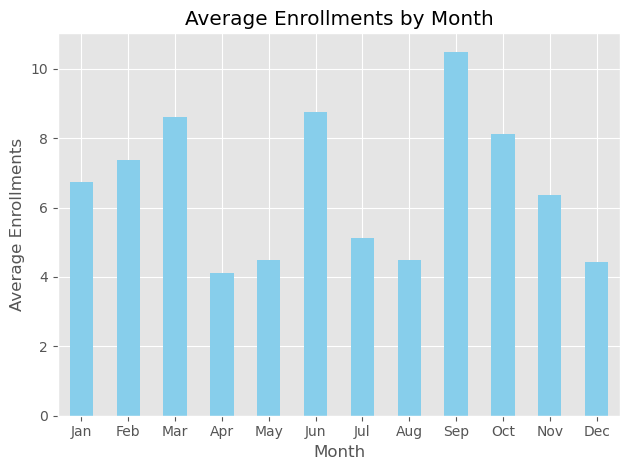

In [336]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
enrollment_mean = enrollment_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
enrollment_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Enrollments by Month')
plt.xlabel('Month')
plt.ylabel('Average Enrollments')
plt.xticks(rotation=0)
plt.tight_layout();

Enrollment End Dates by Month

In [337]:
accounts_end = accounts.copy()
accounts_end.set_index('primary_enrollment_end', inplace=True)
# Filter date >= 2017-01-01 and group by month
filtered_accounts_end = accounts_end[(accounts_end.index >= '2017-01-01') & (accounts_end.index < '2024-12-01')]
filtered_monthly_accounts_end = filtered_accounts_end['membership_type'].resample('M').count()    # Use membership_type because it has no nulls
filtered_monthly_accounts_end.index = pd.to_datetime(filtered_monthly_accounts_end.index)
filtered_monthly_accounts_end.head()


primary_enrollment_end
2017-02-28    1
2017-03-31    1
2017-04-30    2
2017-05-31    1
2017-06-30    7
Freq: M, Name: membership_type, dtype: int64

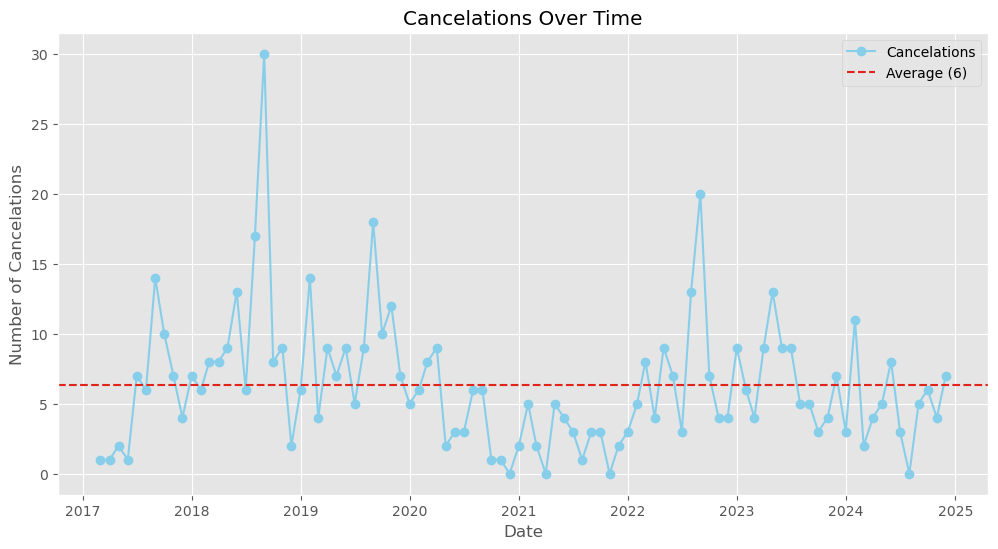

In [338]:
# Plot monthly leads over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_monthly_accounts_end.index, filtered_monthly_accounts_end.values, marker='o', linestyle='-', color='skyblue', label='Cancelations')

# Calculate and plot the mean
average_cancelations = filtered_monthly_accounts_end.mean()
plt.axhline(y=average_cancelations, color='#E2231A', linestyle='--', label=f'Average ({average_cancelations:.0f})')

# Add title and labels
plt.title('Cancelations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cancelations')
plt.legend()
plt.grid(True)
plt.show();

In [339]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_accounts_end = filtered_monthly_accounts_end.to_frame()
filtered_monthly_accounts_end['month'] = filtered_monthly_accounts_end.index.month_name().str[:3]
filtered_monthly_accounts_end.rename(columns={'membership_type': 'cancelations'}, inplace=True)

# Group by month and calculate the mean for each
cancelation_mean = filtered_monthly_accounts_end.groupby('month').mean()
cancelation_mean

,cancelations
month,
Apr,6.500000
Aug,12.625000
Dec,5.000000
Feb,4.625000
Jan,7.571429
Jul,7.125000
Jun,4.875000
Mar,5.500000
May,6.750000


<Figure size 1000x600 with 0 Axes>

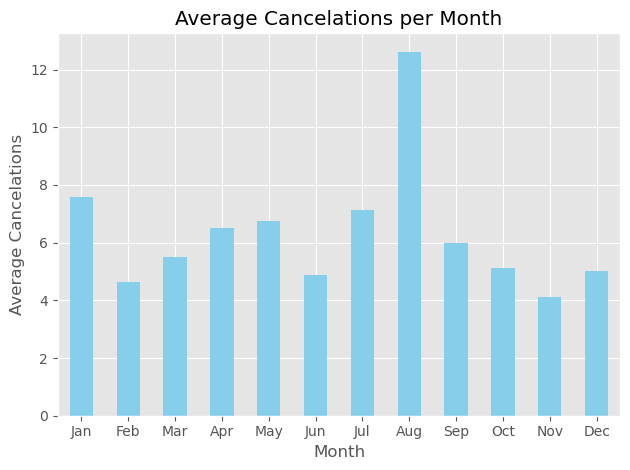

In [340]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
cancelation_mean = cancelation_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
cancelation_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Cancelations per Month')
plt.xlabel('Month')
plt.ylabel('Average Cancelations')
plt.xticks(rotation=0)
plt.tight_layout();

In [341]:
enrollment_mean

,enrollments
month,
Jan,6.750000
Feb,7.375000
Mar,8.625000
Apr,4.125000
May,4.500000
Jun,8.750000
Jul,5.125000
Aug,4.500000
Sep,10.500000


In [342]:
cancelation_mean

,cancelations
month,
Jan,7.571429
Feb,4.625000
Mar,5.500000
Apr,6.500000
May,6.750000
Jun,4.875000
Jul,7.125000
Aug,12.625000
Sep,6.000000


In [343]:
net_monthly_change = enrollment_mean['enrollments'] - cancelation_mean['cancelations']
net_monthly_change

month
Jan   -0.821429
Feb    2.750000
Mar    3.125000
Apr   -2.375000
May   -2.250000
Jun    3.875000
Jul   -2.000000
Aug   -8.125000
Sep    4.500000
Oct    3.000000
Nov    2.250000
Dec   -0.571429
dtype: float64

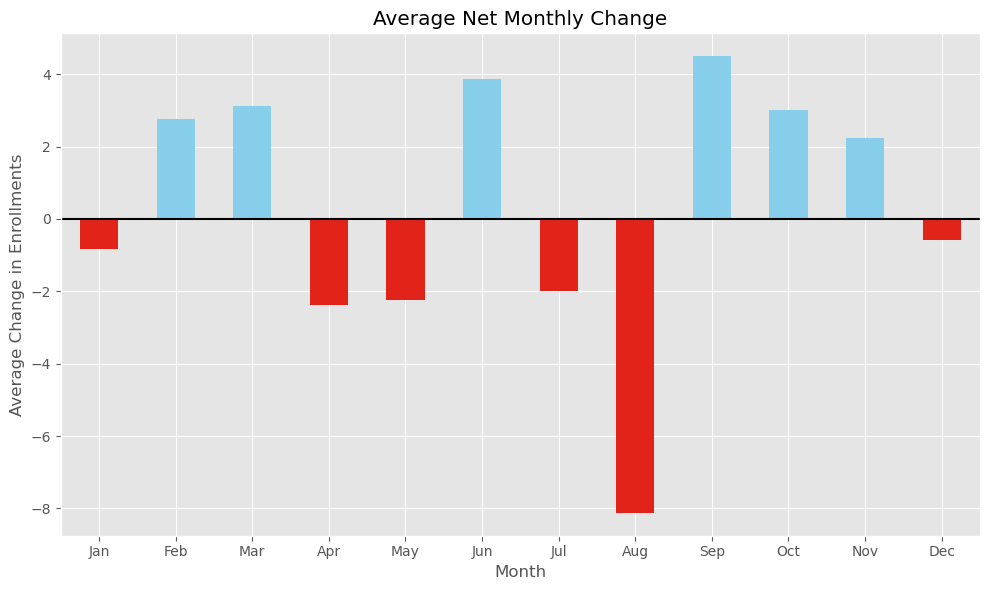

In [344]:
# Plot
plt.figure(figsize=(10, 6))
colors = ['#E2231A' if value < 0 else 'skyblue' for value in net_monthly_change]
net_monthly_change.plot(kind='bar', color=colors, legend=False)

# Add title and labels
plt.title('Average Net Monthly Change')
plt.xlabel('Month')
plt.ylabel('Average Change in Enrollments')
plt.xticks(rotation=0)
plt.axhline(0, color='black')  # Add a reference line at 0
plt.tight_layout();

In [345]:
# Percentage of families that cancel before they complete their agreement
early_cancel = accounts.loc[accounts['enrollment_length_of_stay'] < accounts['enrollment_contract_length']]
early_cancel_percentage = len(early_cancel) / len(accounts) * 100
print(f'The percentage of families that complete their entire enrollment agreement is {100 - early_cancel_percentage:.0f}%')
print(f'The percentage of families that cancel their program before the end of their agreement is: {early_cancel_percentage:.0f}%')

The percentage of families that complete their entire enrollment agreement is 80%
The percentage of families that cancel their program before the end of their agreement is: 20%


In [346]:
accounts.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
primary_enrollment_start,,,,,,,,
2013-06-28,13,Inactive,Flexible,2014-08-31,14.1,14.1,0,0
2014-07-17,13,Inactive,Flexible,2015-04-30,9.4,9.4,0,0
2015-02-22,13,Inactive,Flexible,2016-01-31,11.3,11.3,0,0
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0


In [347]:
mean_length_of_stay = accounts['enrollment_length_of_stay'].mean()
print(f'On average students stay enrolled for {mean_length_of_stay:.1f} months per enrollment agreeement.')

On average students stay enrolled for 6.5 months per enrollment agreeement.


___

### Students

In [348]:
# Inspect contents
assessment_progress = pd.read_csv(assessment_progress_location)
assessment_progress = standardize_columns(assessment_progress)
assessment_progress.head()

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,pre_assess_date,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
0,9,8,2,0.25301,6/4/2018,0.56626,4/9/2019,32,0.31325,0.003132,0.030820,14
1,7,7,3,0.43564,1/11/2023,0.93069,11/6/2023,16,0.49505,0.007501,0.050330,66
2,6,4,1,0.30337,7/5/2021,0.65168,8/3/2021,7,0.34831,0.029026,0.354115,11
3,6,5,1,0.34567,10/8/2019,1.00000,5/13/2020,33,0.65433,0.008610,0.091128,74
4,7,6,2,0.32558,4/2/2020,0.86046,9/16/2020,32,0.53488,0.010092,0.097106,51


In [349]:
assessment_progress['pre_assess_date'] = pd.to_datetime(assessment_progress['pre_assess_date'])
assessment_progress.sort_values(by='pre_assess_date', ascending=True, inplace=True)
assessment_progress.set_index('pre_assess_date', inplace=True)

In [350]:
assessment_progress.head()

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
pre_assess_date,,,,,,,,,,,
2013-06-28,NaN,3,2,0.4576,0.7966,6/2/2014,0,0.3390,0.005060,0.030410,0
2014-07-17,NaN,4,1,0.5070,0.5915,9/27/2014,0,0.0845,0.002414,0.035305,0
2015-02-23,NaN,4,1,0.5169,0.7191,9/14/2015,0,0.2022,0.002379,0.030231,0
2015-06-22,NaN,3,3,0.3857,0.5429,1/21/2017,66,0.1572,0.001391,0.008267,0
2016-07-19,NaN,5,1,0.3704,0.3704,11/16/2016,50,0.0000,0.000000,0.000000,0


In [351]:
assessment_progress.shape

(356, 11)

In [352]:
assessment_progress.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 356 entries, 2013-06-28 to 2024-10-07
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   grade_on_post_dt.           341 non-null    object 
 1   assessment_level            356 non-null    object 
 2   #_post_attempts             356 non-null    int64  
 3   pre_assess_score            338 non-null    float64
 4   post_assess_score           338 non-null    float64
 5   post_assess_date            356 non-null    object 
 6   #_pks_mastered              356 non-null    int64  
 7   score_improvement           338 non-null    float64
 8   improvement/session         338 non-null    float64
 9   improvement/month           338 non-null    float64
 10  attendance_count_in_center  356 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 33.4+ KB


In [353]:
assessment_progress.isna().sum()

grade_on_post_dt.             15
assessment_level               0
#_post_attempts                0
pre_assess_score              18
post_assess_score             18
post_assess_date               0
#_pks_mastered                 0
score_improvement             18
improvement/session           18
improvement/month             18
attendance_count_in_center     0
dtype: int64

In [354]:
assessment_progress.describe()

,#_post_attempts,pre_assess_score,post_assess_score,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
count,356.000000,338.000000,338.000000,356.000000,338.000000,338.000000,338.000000,356.000000
mean,1.480337,0.475419,0.787902,13.808989,0.312483,0.010268,0.078593,33.471910
std,0.759656,0.190969,0.199241,13.199126,0.182150,0.020990,0.100782,41.362796
min,1.000000,0.083330,0.111100,0.000000,-0.674160,-0.037037,-0.447157,0.000000
25%,1.000000,0.325635,0.667905,5.000000,0.208330,0.004768,0.039238,9.750000
50%,1.000000,0.457120,0.839650,11.000000,0.298250,0.007756,0.061747,25.000000
75%,2.000000,0.627175,0.954275,18.000000,0.421050,0.012012,0.097036,45.000000
max,5.000000,1.000000,1.000000,114.000000,0.892860,0.355560,0.847226,366.000000


Assessment data includes all assessments for students where at least one post assessment has been attempted. There are 356 assessments matching this criteria from 2000-01-01 to 2024-12-09. Each assessment is measured across 11 features:
* grade_on_post_dt. - Grade of student at time of post assessment. Convert to int.
* assessment_level - Can be used to calculate disparity between grade and perforance. Convert to int.
* #_post_attempts - Number of attempts on post-assessment (>= 80 moves to next assessment level)
* pre_assess_score - Range between 8-100% with mean and median near 45%
* post_assess_score - Range between 11-100% with mean and median near 80%
* post_assess_date - Date of post-assessment. Convert to datetime.
* #_pks_mastered - Lessons mastered between pre and post dates. Mean is 14, median is 11.
* score_improvement - From pre to post assessment
* improvement/session - Improvement divided by attendance for assessment period. 
* improvement/month - Improvement divided by time between pre and post assessment. Roughly +6-7% per month
* attendance_count_in_center - Number of sessions in assessment period. Positive skew with mean at 33 and median at 25

Will need to look at nulls:
* 15 in grade_on_post_dt.
* 18 in several other columns (same data?)

___

In [355]:
# Use grade_map to replace 'K' and 'College'
assessment_progress['grade_on_post_dt.'] = assessment_progress['grade_on_post_dt.'].replace(grade_map)

# Make post_assess_date datetime
assessment_progress['post_assess_date'] = pd.to_datetime(assessment_progress['post_assess_date'])

In [356]:
assessment_progress.head()

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
pre_assess_date,,,,,,,,,,,
2013-06-28,NaN,3,2,0.4576,0.7966,2014-06-02,0,0.3390,0.005060,0.030410,0
2014-07-17,NaN,4,1,0.5070,0.5915,2014-09-27,0,0.0845,0.002414,0.035305,0
2015-02-23,NaN,4,1,0.5169,0.7191,2015-09-14,0,0.2022,0.002379,0.030231,0
2015-06-22,NaN,3,3,0.3857,0.5429,2017-01-21,66,0.1572,0.001391,0.008267,0
2016-07-19,NaN,5,1,0.3704,0.3704,2016-11-16,50,0.0000,0.000000,0.000000,0


In [357]:
# Will use median grade to fill nulls
assessment_progress.loc[assessment_progress['grade_on_post_dt.'].isna() == True]

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
pre_assess_date,,,,,,,,,,,
2013-06-28,NaN,3,2,0.4576,0.79660,2014-06-02,0,0.33900,0.005060,0.030410,0
2014-07-17,NaN,4,1,0.5070,0.59150,2014-09-27,0,0.08450,0.002414,0.035305,0
2015-02-23,NaN,4,1,0.5169,0.71910,2015-09-14,0,0.20220,0.002379,0.030231,0
2015-06-22,NaN,3,3,0.3857,0.54290,2017-01-21,66,0.15720,0.001391,0.008267,0
2016-07-19,NaN,5,1,0.3704,0.37040,2016-11-16,50,0.00000,0.000000,0.000000,0
2017-02-19,NaN,5,1,0.3636,0.11110,2017-03-10,2,-0.25250,-0.028056,-0.385062,0
2017-02-21,NaN,1,1,0.7917,0.45450,2017-03-15,2,-0.33720,-0.033720,-0.447157,0
2017-04-09,NaN,2,1,0.7368,1.00000,2017-05-23,7,0.26320,0.029244,0.178391,0
2017-05-14,NaN,5,1,0.7284,1.00000,2017-08-17,18,0.27160,0.007760,0.086290,0


In [358]:
# Find the median post grade for each level assessment
median_post_grade_per_assessment_level = assessment_progress.groupby(['assessment_level'])['grade_on_post_dt.'].median()

# Fill nulls with median value
assessment_progress['grade_on_post_dt.'] = assessment_progress['grade_on_post_dt.'].fillna(
    assessment_progress['assessment_level'].map(median_post_grade_per_assessment_level)
)


In [359]:
# NF type assessment gets assigned a mastery level, not a numeric score. 
# Because structure and depth of learning plan differ from other types of assessments I'll drop these.
assessment_progress.loc[assessment_progress['pre_assess_score'].isna() == True]

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center
pre_assess_date,,,,,,,,,,,
2018-07-16,2,NF,1,NaN,NaN,2018-11-13,10,NaN,NaN,NaN,0
2021-12-01,6,NF,1,NaN,NaN,2022-03-29,2,NaN,NaN,NaN,16
2023-03-16,9,NF,1,NaN,NaN,2023-11-02,17,NaN,NaN,NaN,85
2023-06-09,7,NF,1,NaN,NaN,2023-07-12,5,NaN,NaN,NaN,17
2023-06-09,7,NF,2,NaN,NaN,2023-07-13,1,NaN,NaN,NaN,18
2023-06-12,5,NF,1,NaN,NaN,2023-07-18,8,NaN,NaN,NaN,16
2023-06-13,7,NF,1,NaN,NaN,2023-09-12,9,NaN,NaN,NaN,21
2023-06-14,5,NF,1,NaN,NaN,2023-09-11,4,NaN,NaN,NaN,25
2023-06-22,7,NF,1,NaN,NaN,2023-09-21,11,NaN,NaN,NaN,26


In [360]:
# Calculate percent of assessments that are NF
percentage_nf_assessments = len(assessment_progress.loc[assessment_progress['pre_assess_score'].isna() == True]) / len(assessment_progress) * 100
print(f'{percentage_nf_assessments:.0f}% of all assessments are NF.')

5% of all assessments are NF.


In [361]:
# Drop NF-type assessments
assessment_progress = assessment_progress.dropna()

In [362]:
# Convert grade_on_post_dt. and assessment_level to numeric columns
assessment_progress['grade_on_post_dt.'] = pd.to_numeric(assessment_progress['grade_on_post_dt.'])
assessment_progress['assessment_level'] = pd.to_numeric(assessment_progress['assessment_level'])

In [363]:
# Calculate performance relative to grade level
assessment_progress['relative_performance'] = assessment_progress['assessment_level'] - assessment_progress['grade_on_post_dt.']

In [364]:
assessment_progress.loc[assessment_progress['grade_on_post_dt.'] == 4]

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center,relative_performance
pre_assess_date,,,,,,,,,,,,
2017-09-01,4.0,4,2,0.64040,1.00000,2017-12-27,28,0.35960,0.005065,0.092947,0,0.0
2017-09-19,4.0,4,2,0.67420,1.00000,2018-04-30,23,0.32580,0.003359,0.044361,0,0.0
2017-10-12,4.0,3,2,0.70000,0.87142,2019-04-09,22,0.17142,0.001417,0.009593,4,-1.0
2017-12-27,4.0,5,1,0.79012,1.00000,2018-03-06,12,0.20988,0.005672,0.091448,0,1.0
2018-01-28,4.0,4,1,0.61797,1.00000,2018-05-09,18,0.38203,0.008682,0.114234,0,0.0
2018-01-28,4.0,3,1,0.50000,1.00000,2018-10-08,16,0.50000,0.006173,0.060039,0,-1.0
2018-03-15,4.0,3,1,0.30000,0.62857,2018-09-20,15,0.32857,0.004762,0.052744,0,-1.0
2018-05-31,4.0,3,2,0.31428,1.00000,2019-05-02,29,0.68572,0.006068,0.062061,25,-1.0
2018-08-13,4.0,1,1,0.27272,1.00000,2019-04-18,22,0.72728,0.007992,0.089084,25,-3.0


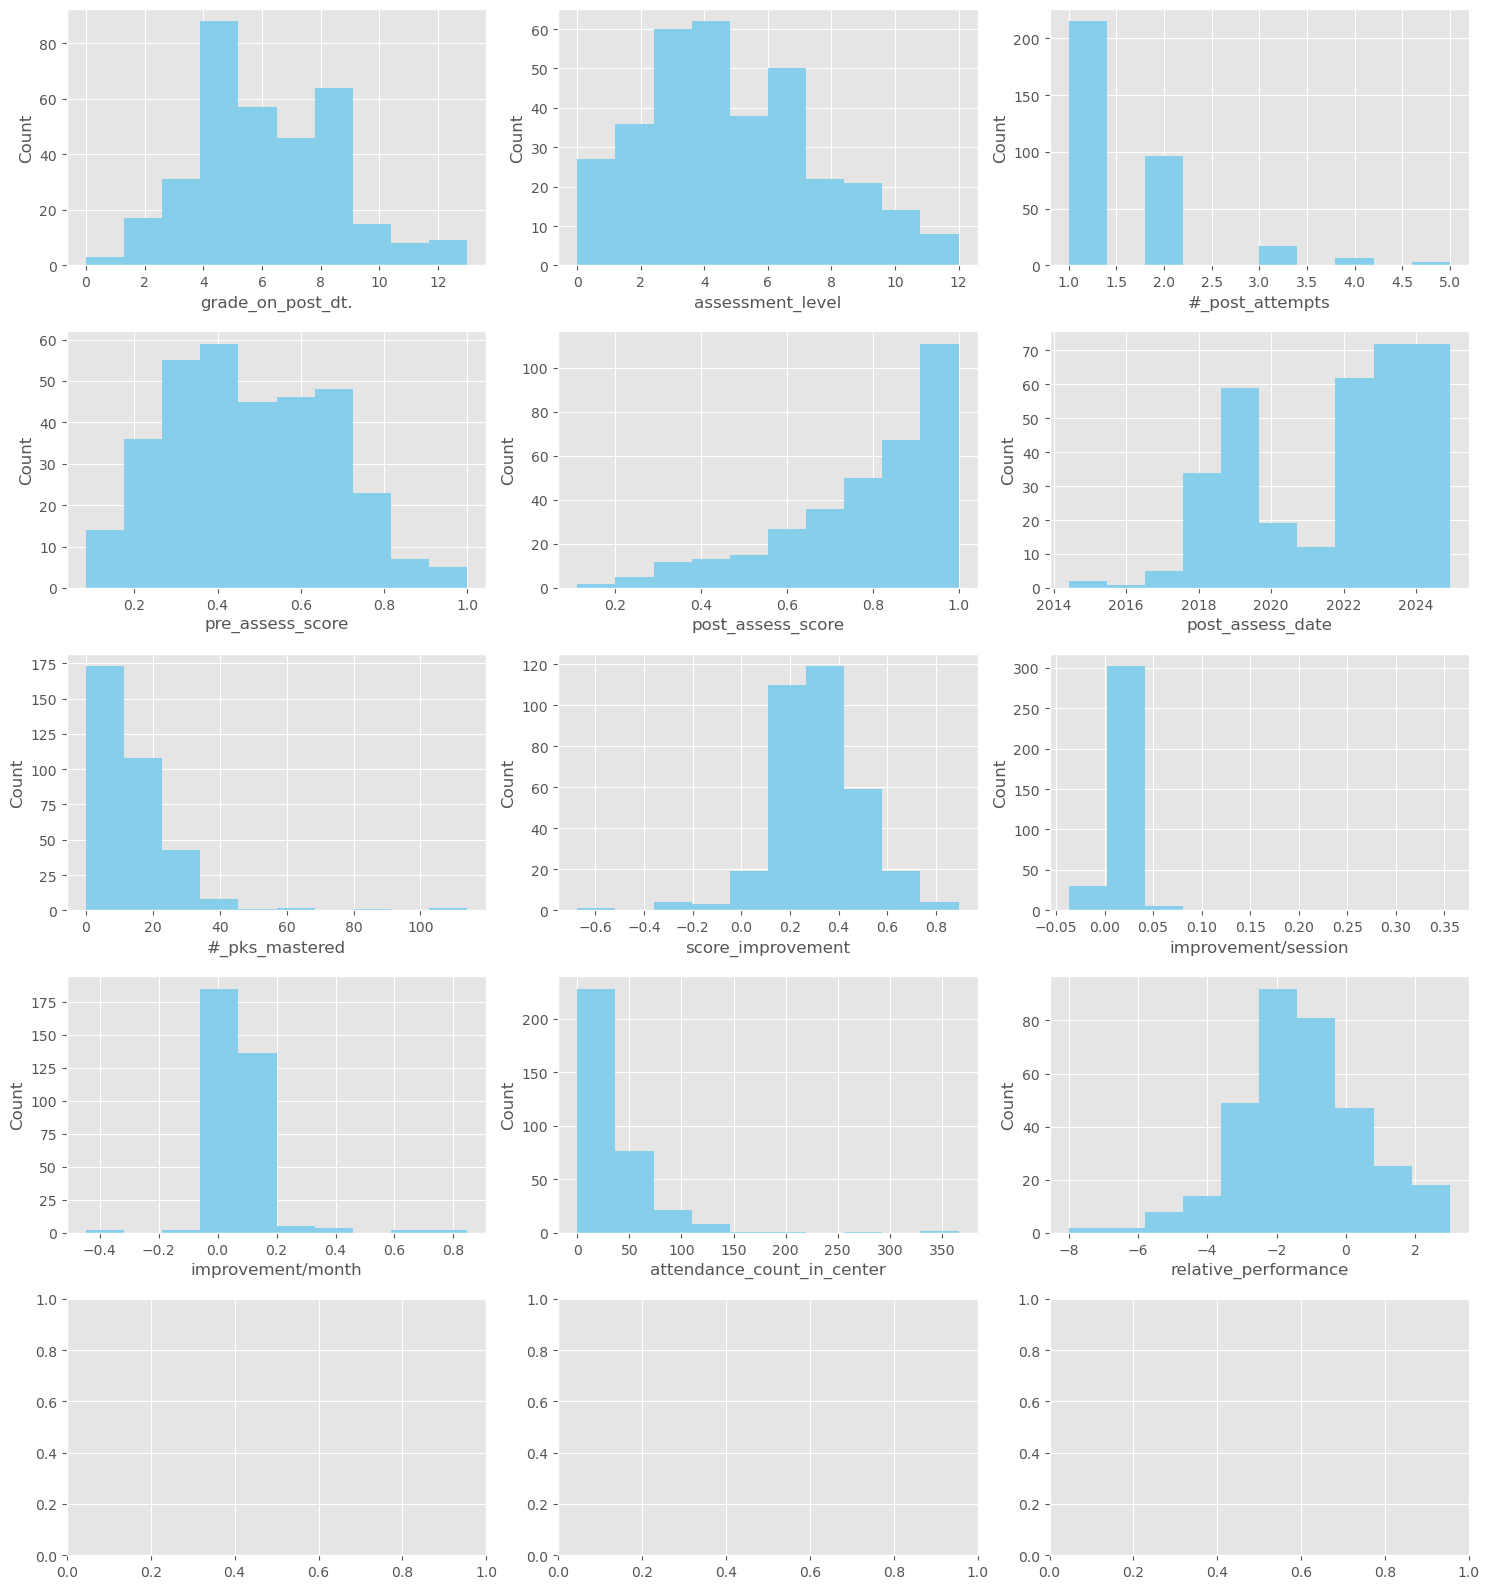

In [365]:
# Create a 3x5 grid
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
axes = axes.flatten()

# Apply to each column
for i, column in enumerate(assessment_progress.columns):
    
    # Horizontal bar plots
    axes[i].hist(assessment_progress[column], color='skyblue')
    
    # Add title and labels
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout();

In [366]:
# Average test-taker relative_performance
mean_relative_performance = assessment_progress['relative_performance'].mean()
print(f'Students who have completed a pre-assessment and post-assessment for the same level are, on average {mean_relative_performance:.1f} grades from grade level.')

Students who have completed a pre-assessment and post-assessment for the same level are, on average -1.4 grades from grade level.


NOTE: This includes data for students that have completed multiple levels and excludes students that have yet to take a post assessment.

In [367]:
# Loop calculates average change in assessment score based on number of attempts

# Initialize
cumulative_performance = 0
performance_per_attempt = []

for attempt in range(1, assessment_progress['#_post_attempts'].max() + 1):

    # Calculate current iteration performance and take away effects of previous iterations
    current_performance = assessment_progress.loc[assessment_progress['#_post_attempts'] == attempt]['score_improvement'].mean() - cumulative_performance
    print(f"Average performance after {attempt} attempt(s) is: {(current_performance) * 100:.1f}%")

    # Add to cumulative performance for deduction in later iterations
    cumulative_performance += current_performance
    performance_per_attempt.append((attempt, current_performance * 100))

Average performance after 1 attempt(s) is: 27.4%
Average performance after 2 attempt(s) is: 8.5%
Average performance after 3 attempt(s) is: 6.5%
Average performance after 4 attempt(s) is: 9.3%
Average performance after 5 attempt(s) is: -7.7%


In [368]:
performance_per_attempt

[(1, 27.421372093023255),
 (2, 8.523492490310074),
 (3, 6.495664828431375),
 (4, 9.289327731092435),
 (5, -7.722523809523807)]

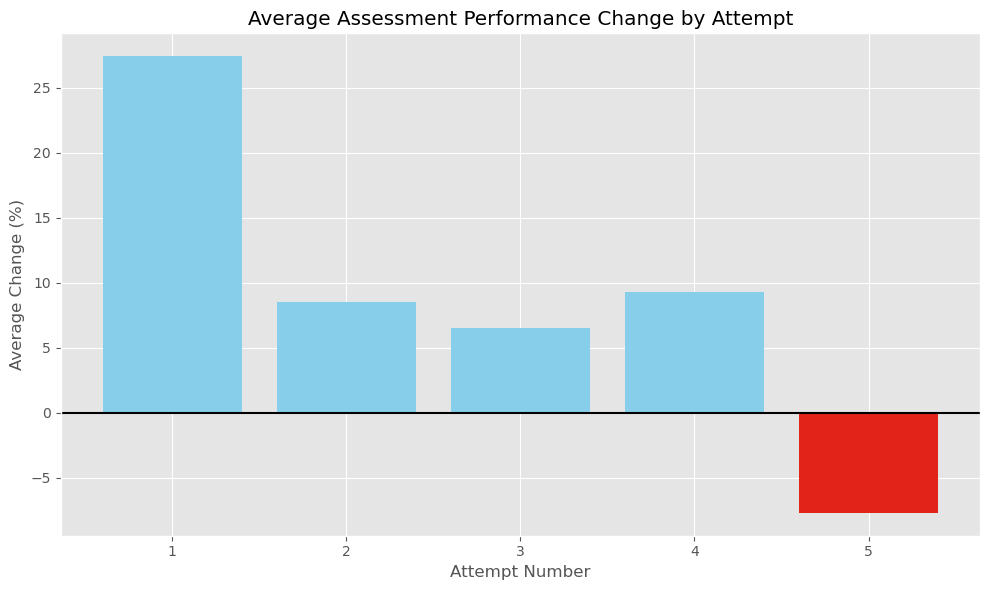

In [369]:
performance_df = pd.DataFrame(performance_per_attempt, columns=['attempt', 'performance'])

colors = ['#E2231A' if value < 0 else 'skyblue' for value in performance_df['performance']]


plt.figure(figsize=(10, 6))
plt.bar(performance_df['attempt'], performance_df['performance'], color=colors)

# Add labels and title
plt.title('Average Assessment Performance Change by Attempt')
plt.xlabel('Attempt Number')
plt.ylabel('Average Change (%)')
plt.xticks(performance_df['attempt'])
plt.yticks()
plt.axhline(0, color='black')  # Add a reference line at 0

# Display the plot
plt.tight_layout()
plt.show();

Decline in assessment performance may be caused by several factors:
* There is less content to master as score rises.
* The remaining content is especially challenging for the student.
* The student may feel burntout after several iterations of the same content.

Generally, students are promoted to the next level when they get at least 80% on their post assessment. Let's take a closer look at the trends that allow a student to move from one level to the next.

In [370]:
# Isolate rows where post_assess_score >= 80%
next_level_assessments = assessment_progress.loc[assessment_progress['post_assess_score'] >= 0.8]
next_level_assessments.shape

(196, 12)

In [371]:
# Calculate elapsed time in months
next_level_assessments['elapsed_months'] = round((next_level_assessments['post_assess_date'] - next_level_assessments.index).dt.days / 30.44, 1)
next_level_assessments.head()

C:\Users\Elija\AppData\Local\Temp\ipykernel_23328\3762714973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_level_assessments['elapsed_months'] = round((next_level_assessments['post_assess_date'] - next_level_assessments.index).dt.days / 30.44, 1)


,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center,relative_performance,elapsed_months
pre_assess_date,,,,,,,,,,,,,
2017-02-04,5.0,6,2,0.7442,0.95348,2022-12-04,0,0.20928,0.007474,0.002997,27,1.0,69.9
2017-03-29,5.0,4,1,0.3258,1.00000,2017-12-10,30,0.67420,0.004994,0.080012,0,-1.0,8.4
2017-04-09,3.0,2,1,0.7368,1.00000,2017-05-23,7,0.26320,0.029244,0.178391,0,-1.0,1.4
2017-05-14,6.5,5,1,0.7284,1.00000,2017-08-17,18,0.27160,0.007760,0.086290,0,-1.5,3.1
2017-06-05,6.0,5,1,0.3457,1.00000,2018-03-14,28,0.65430,0.008282,0.070516,0,-1.0,9.3


In [372]:
next_level_assessments.describe()

,grade_on_post_dt.,assessment_level,#_post_attempts,pre_assess_score,post_assess_score,post_assess_date,#_pks_mastered,score_improvement,improvement/session,improvement/month,attendance_count_in_center,relative_performance,elapsed_months
count,196.000000,196.000000,196.000000,196.000000,196.000000,196,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,5.714286,4.459184,1.525510,0.558382,0.925840,2021-06-10 08:26:56.326530560,16.693878,0.367459,0.012143,0.099118,34.484694,-1.255102,5.998980
min,1.000000,0.000000,1.000000,0.107140,0.800000,2017-05-23 00:00:00,0.000000,-0.116300,-0.002769,-0.041731,0.000000,-8.000000,0.400000
25%,4.000000,3.000000,1.000000,0.435640,0.863310,2019-03-19 06:00:00,9.000000,0.244190,0.005692,0.049331,0.000000,-2.000000,2.800000
50%,5.500000,4.000000,1.000000,0.578940,0.929195,2022-01-02 00:00:00,15.000000,0.359575,0.008261,0.079361,25.000000,-1.000000,4.600000
75%,7.000000,6.000000,2.000000,0.674162,1.000000,2023-07-24 18:00:00,21.000000,0.470583,0.012122,0.111635,44.500000,0.000000,7.125000
max,13.000000,12.000000,5.000000,1.000000,1.000000,2024-11-26 00:00:00,114.000000,0.892860,0.355560,0.847226,366.000000,3.000000,69.900000
std,2.295481,2.633778,0.806615,0.172448,0.069539,NaN,14.365849,0.165879,0.026079,0.107838,48.525592,1.778425,6.310723


* Average attempts is 1.5 to move from one level to the next.
* Students who complete a given level average 92% on their post-assessment.
* It takes roughly 15-17 PKs to reach mastery from initial assessment score near 55%.
* It takes roughly 25 (median) to 34 (mean) visits to progress from one level to the next.
* It takes roughly 4.5 (median) to 6 (mean) months to progress from one level to the next.

The discrepancy between number of visits required (and therefore time) to complete a level is influenced by factors such as:
* Score on pre-assessment
* The portion of the sessions dedicated to PKs vs school work
* Consistent student attendance

___

### Summary of Data Findings

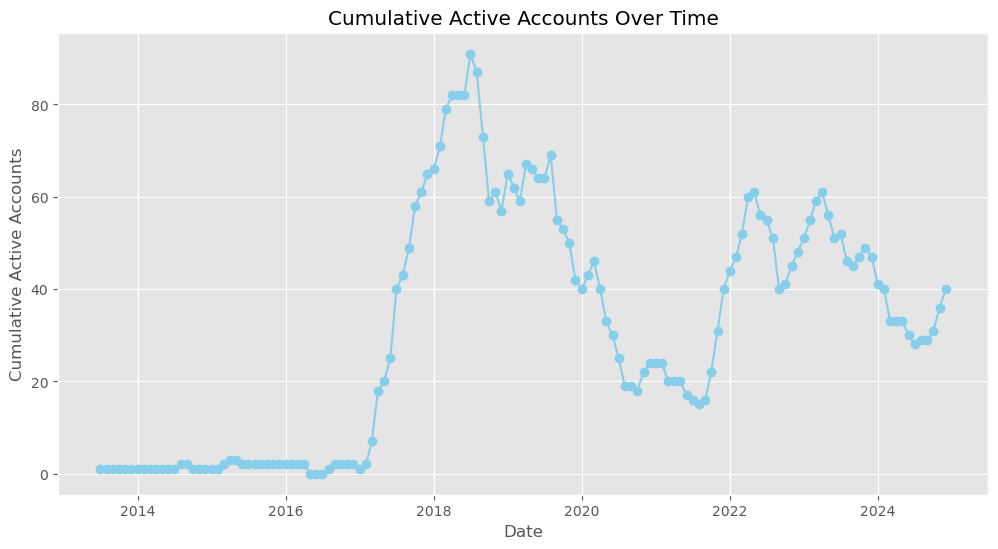

In [373]:
# Generate a date range for all months in the data
date_range = pd.date_range(
    start=accounts.index.min(), 
    end=accounts.index.max(), 
    freq='M'
)

# Create an empty DataFrame to hold cumulative counts
cumulative_enrollments = pd.DataFrame(index=date_range, columns=['active_accounts'])
cumulative_enrollments['active_accounts'] = 0  # Initialize with zeros

# Calculate cumulative enrollments for each month
for date in date_range:
    cumulative_enrollments.loc[date, 'active_accounts'] = accounts[
        (date >= accounts.index) & 
        ((date <= accounts['primary_enrollment_end']) | (accounts['primary_enrollment_end'].isna()))
    ].shape[0]

# Plot the cumulative enrollments
plt.figure(figsize=(12, 6))
plt.plot(cumulative_enrollments.index, cumulative_enrollments['active_accounts'], marker='o', color='skyblue')
plt.title('Cumulative Active Accounts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Active Accounts')
plt.grid(True)
plt.show();

## Potential Routes of Analysis


## Chosen Metrics for Analysis


## Data Cleaning & Feature Engineering

## Analysis

### Direction 1


#### Direction 1 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 1:

### Direction 2


#### Direction 2 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 2:

### Direction 3

#### Direction 3 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 3:

## Results


### Direction 1
* 


### Direction 2
* 


### Direction 3
* 

## Conclusions
This analysis leads to three recommendations.

1. 

2. 

3. 

## Next Steps
* 